In [1]:
# import fancyimpute as fi
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import variation
from math import isnan

from scipy.cluster.hierarchy import dendrogram,linkage

import sys
sys.path.append("./src/")
import lumberjack
import tree_reader as tr


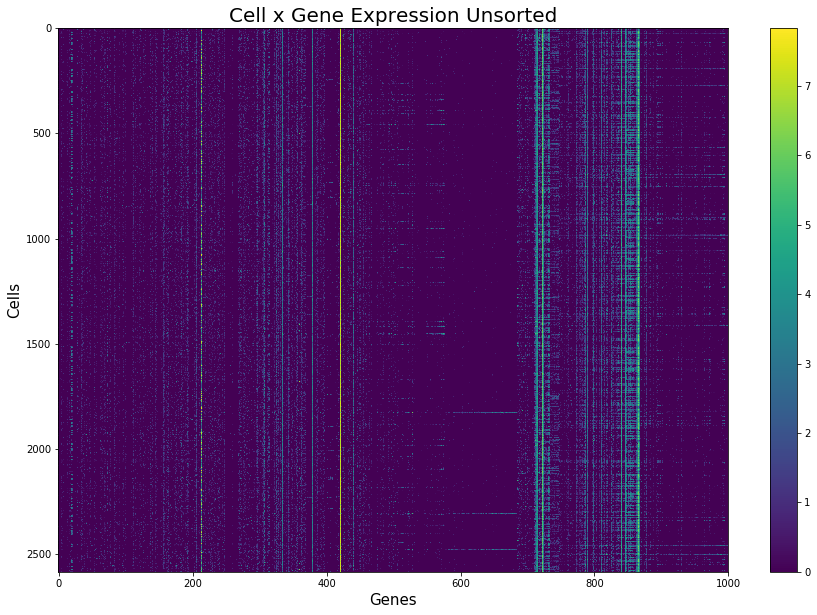

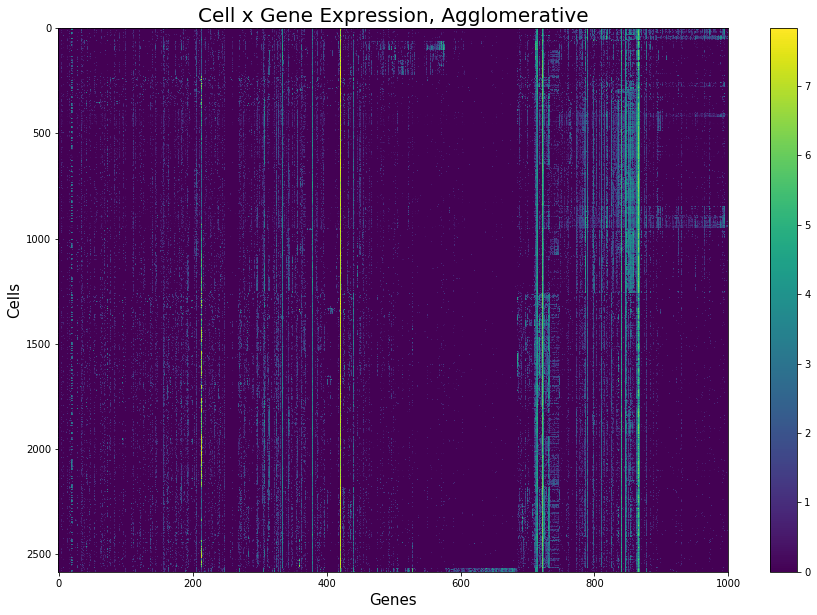

(2585, 1000)
(1000,)


In [2]:
counts = np.loadtxt('/Users/boris/taylor/johnston_retina/single_cell/dmel-retina-scRNA/exploration/2018.07.19_Scanpy/log_counts.txt')
header = np.loadtxt("/Users/boris/taylor/johnston_retina/single_cell/dmel-retina-scRNA/exploration/2018.07.19_Scanpy/header.txt",dtype=str)

# counts = np.loadtxt('/Users/boris/taylor/aging_sc/var_filtered_counts.txt')
# header = np.loadtxt("/Users/boris/taylor/aging_sc/var_filtered_header.txt",dtype=str)

# counts = np.loadtxt('/Users/boris/taylor/fan_tendon/log_counts.txt')
# header = np.loadtxt("/Users/boris/taylor/fan_tendon/header.txt",dtype=str)

feature_sort = dendrogram(linkage(counts.T,metric='correlation'),no_plot=True)['leaves']

# counts = counts[cell_sort].T[feature_sort].T
counts = counts.T[feature_sort].T

plt.figure(figsize=(15,10))
plt.title("Cell x Gene Expression Unsorted",fontsize=20)
plt.imshow(counts,aspect='auto')
plt.xlabel("Genes",fontsize=15)
plt.ylabel("Cells",fontsize=15)
plt.colorbar()
plt.show()

cell_sort = dendrogram(linkage(counts,metric='cos',method='average'),no_plot=True)['leaves']
counts = counts[cell_sort]

plt.figure(figsize=(15,10))
plt.title("Cell x Gene Expression, Agglomerative",fontsize=20)
plt.imshow(counts,aspect='auto')
plt.xlabel("Genes",fontsize=15)
plt.ylabel("Cells",fontsize=15)
plt.colorbar()
plt.show()


print(counts.shape)
print(header.shape)

In [3]:
output_directory = "./prediction/"
raw_text_out = open(output_directory + str("evaluation.txt"),mode='w')



In [4]:

training_mask = np.random.random(counts.shape[0]) > .1
testing_mask = np.logical_not(training_mask)

training_counts = counts[training_mask]
testing_counts = counts[testing_mask]

forest = tr.Forest.reconstitute('./forest_bk_tmp')

# forest = lumberjack.fit(training_counts,trees=100,dispersion_mode="ssme",norm="l1",drop='none',sfr=1,in_feature_subsample=100,out_feature_subsample=100,sample_subsample=1000,depth=10,leaves=100,header=header)

# forest.weigh_leaves()

predicted = forest.predict_matrix(testing_counts)

true_counts = testing_counts

subsampling = 1

# mask = np.loadtxt('./testing/holdout_mask_counts.txt')
# held_out_counts = np.loadtxt('./testing/held_out_counts.txt')

In [5]:
forest.backup('./forest_bk_tmp')

In [6]:
# Optional adjustment to truncate lower-expressing genes.
# expression_level_mask = np.mean(true_counts,axis=0) > 1
# true_counts = true_counts.T[expression_level_mask].T
# predicted = predicted.T[expression_level_mask].T

In [7]:


raw_text_out.write("=================================================\n")
raw_text_out.write("Basic evaluation: \n")

raw_text_out.write("Pearson R\n")
raw_text_out.write(str(pearsonr(predicted.flatten(),true_counts.flatten())) + "\n")

raw_text_out.write("MSE\n")
raw_text_out.write(str(np.mean((predicted.flatten() - true_counts.flatten()) ** 2)) + "\n")

raw_text_out.write("MAE\n")
raw_text_out.write(str(np.mean(np.abs(predicted.flatten() - true_counts.flatten()))) + "\n")


raw_text_out.close()

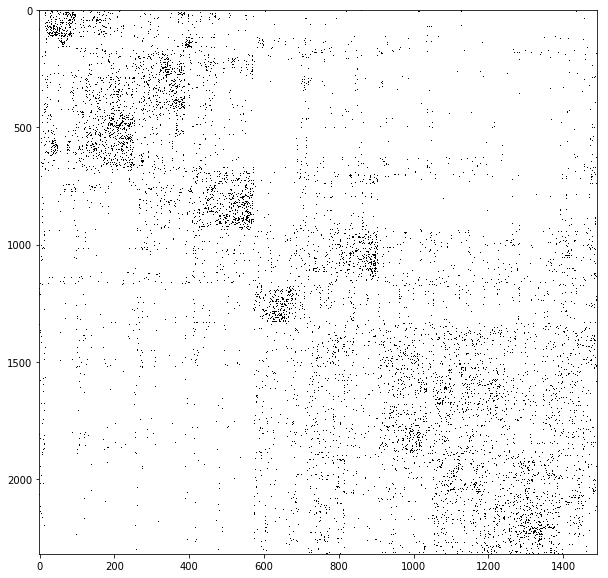

0
Clustering has already been done
Clustering has already been done


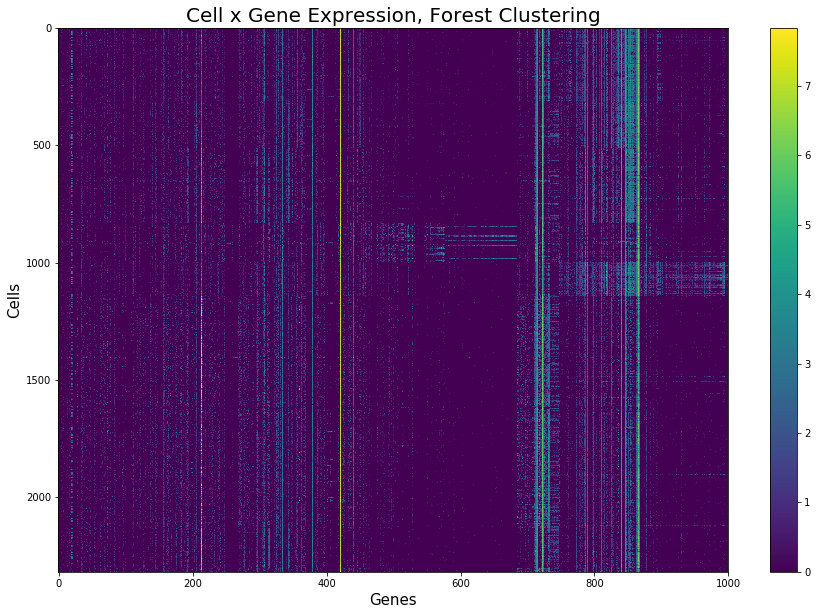

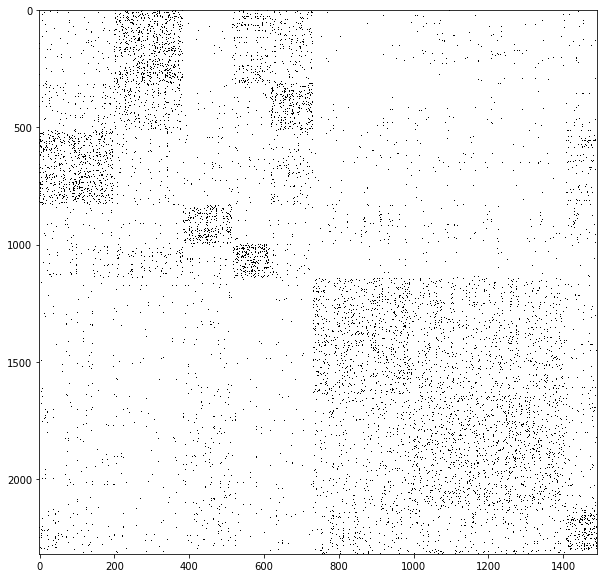

310
202
321
167
143
499
491
172
16


In [8]:
# from scipy.cluster.hierarchy import linkage,dendrogram

encoding = forest.node_sample_encoding(forest.leaves())

# print(np.sum(np.sum(encoding,axis=1) == 0))
cell_sort = dendrogram(linkage(encoding,metric='cos',method='average'),no_plot=True)['leaves']
leaf_sort = dendrogram(linkage(encoding.T,metric='cos',method='average'),no_plot=True)['leaves']

plt.figure(figsize=(10,10))
# plt.imshow(encoding,aspect='auto',cmap='binary')
plt.imshow(encoding[cell_sort].T[leaf_sort].T,aspect='auto',cmap='binary')
plt.show()


print(np.sum(np.isnan(encoding).flatten()))

cell_clusterings = forest.cluster_samples(borrow=1,sample_sub=250,override=False,refining=False,verbose=True)
leaf_clusterings = forest.cluster_leaves(sample_sub=250,borrow=1,override=False,refining=False,verbose=True)

cell_order = np.argsort(cell_clusterings)
leaf_order = np.argsort(leaf_clusterings)
# feature_order = np.argsort(feature_clusterings)

clustered_counts = forest.counts[cell_order]
# clustered_counts = encoding[cell_order].T[leaf_sort].T

plt.figure(figsize=(15,10))
plt.title("Cell x Gene Expression, Forest Clustering",fontsize=20)
plt.imshow(clustered_counts,aspect='auto')
plt.xlabel("Genes",fontsize=15)
plt.ylabel("Cells",fontsize=15)
plt.colorbar()
plt.show()


plt.figure(figsize=(10,10))
plt.imshow(encoding[cell_order].T[leaf_order].T,aspect='auto',cmap='binary')
plt.show()

for cluster in forest.sample_clusters:
    print(len(cluster.samples))

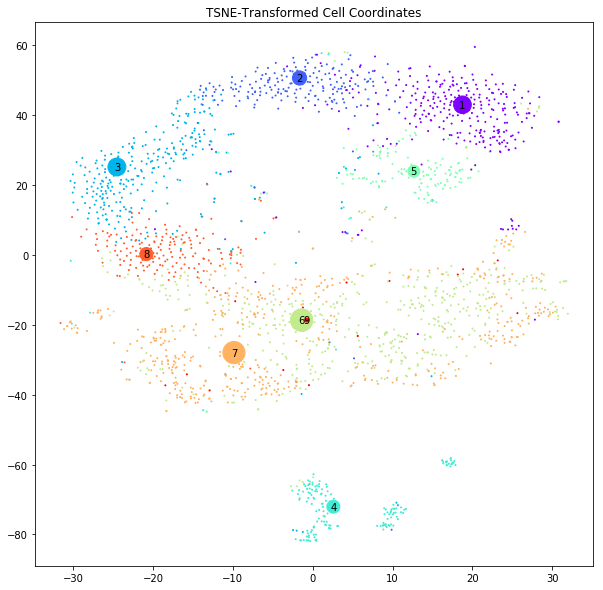

In [9]:
# forest.leaf_clusters[0].ranked_mean_gains()
# forest.leaf_clusters[0].prerequisite_frequency()
# forest.leaf_clusters[3].biological_cluster_summary()
# print(forest.weighted_node_vector_prediction(forest.leaf_clusters[0].nodes))
# print(forest.weighted_node_vector_prediction([forest.prototype.root]))
forest.plot_cell_clusters()

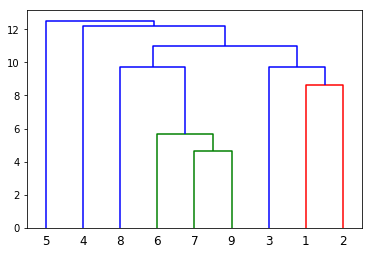

In [10]:
plt.figure()
dendrogram(linkage(forest.sample_cluster_coordinate_matrix()),labels=[cluster.id for cluster in forest.sample_clusters])
plt.show()

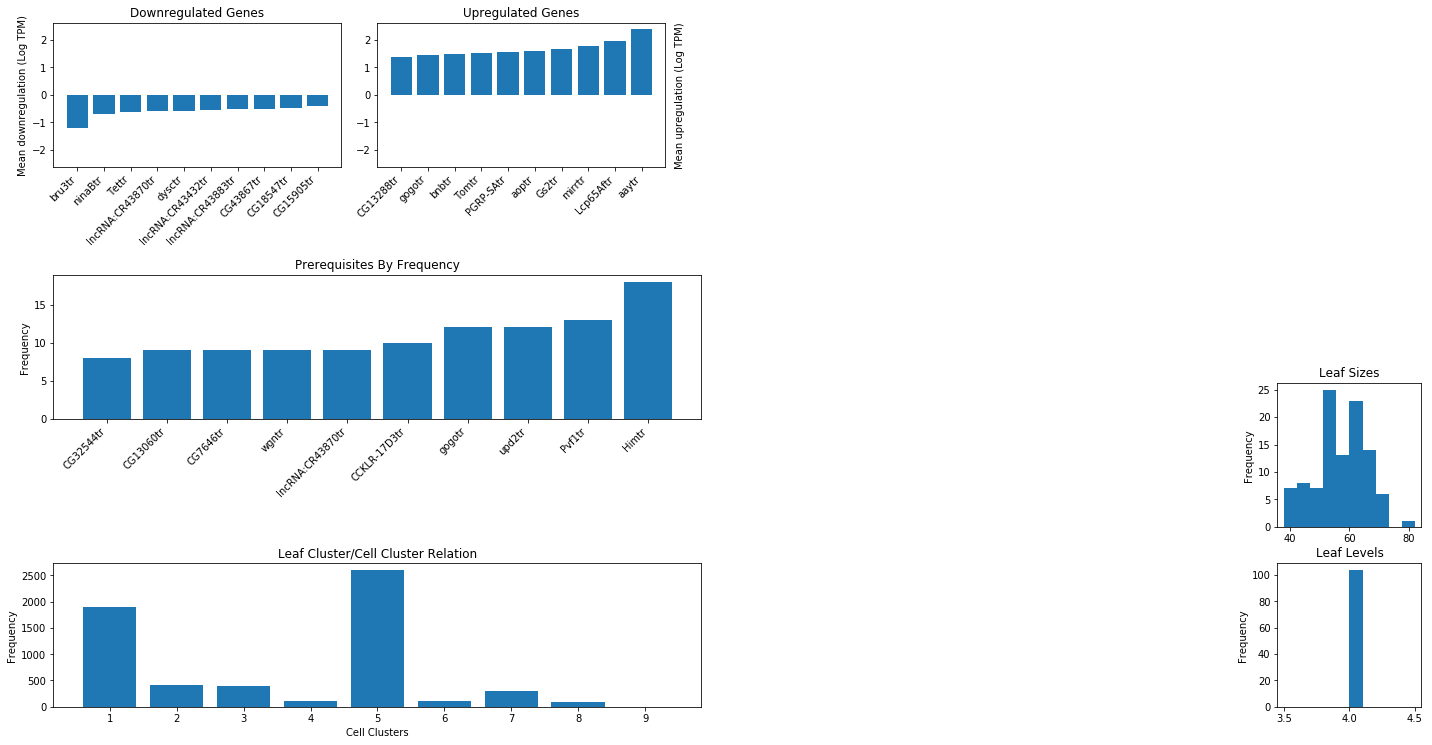

In [11]:
forest.leaf_clusters[3].biological_cluster_summary()

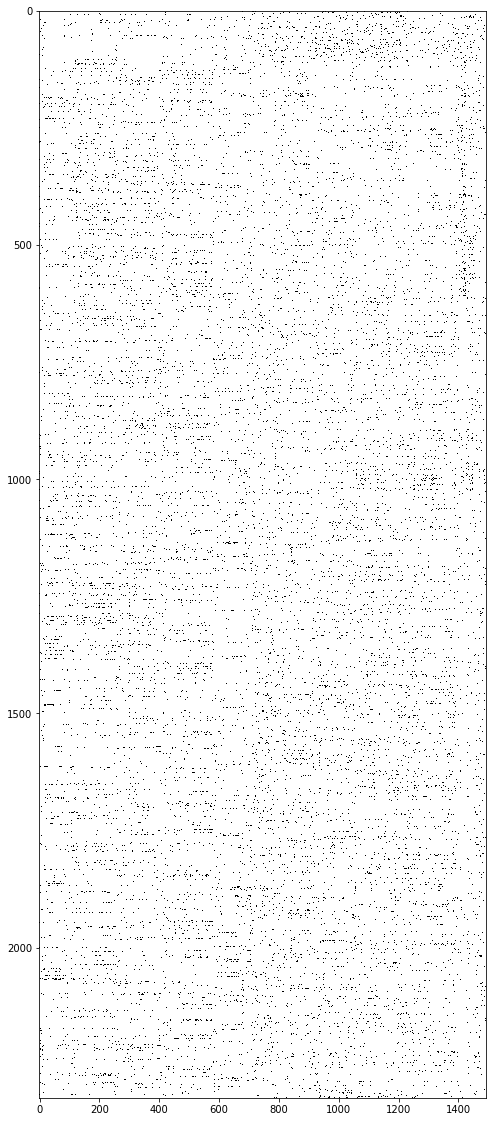

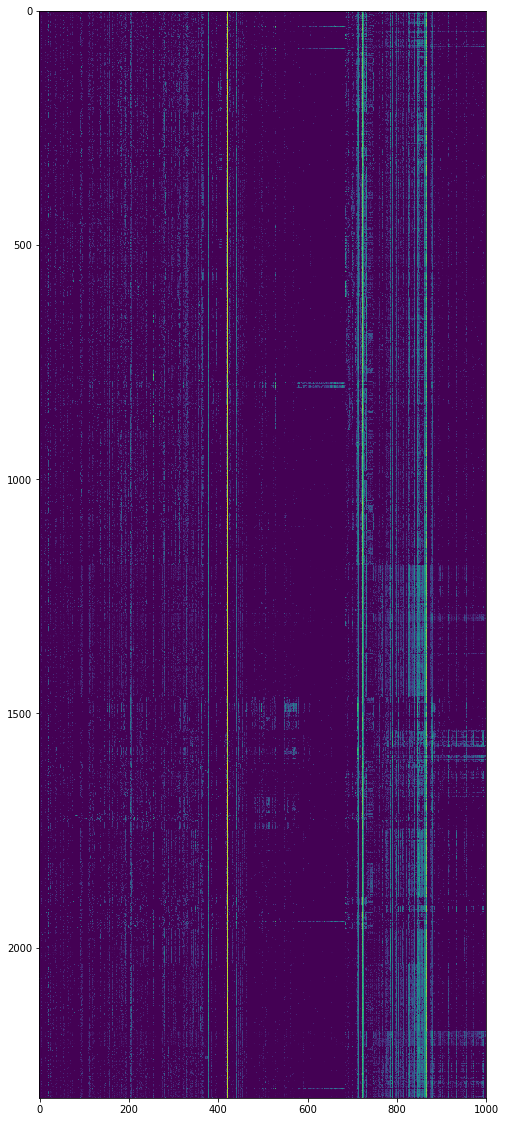

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}


In [12]:
# from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN

encoding = forest.node_sample_encoding(forest.leaves())

d_cell_clusters = HDBSCAN(min_samples=5).fit_predict(encoding)
d_leaf_clusters = HDBSCAN(min_samples=5).fit_predict(encoding.T)

d_cell_ordering = np.argsort(d_cell_clusters)
# leaf_ordering = np.argsort(d_leaf_clusters)
d_leaf_ordering = dendrogram(linkage(encoding.T,metric='cos',method='average'),no_plot=True)['leaves']


plt.figure(figsize=(8,20))
plt.imshow(encoding[d_cell_ordering].T[d_leaf_ordering].T,aspect='auto',cmap='binary')
plt.show()

plt.figure(figsize=(8,20))
plt.imshow(training_counts[d_cell_ordering],aspect='auto')
plt.show()

print(set(d_cell_clusters))

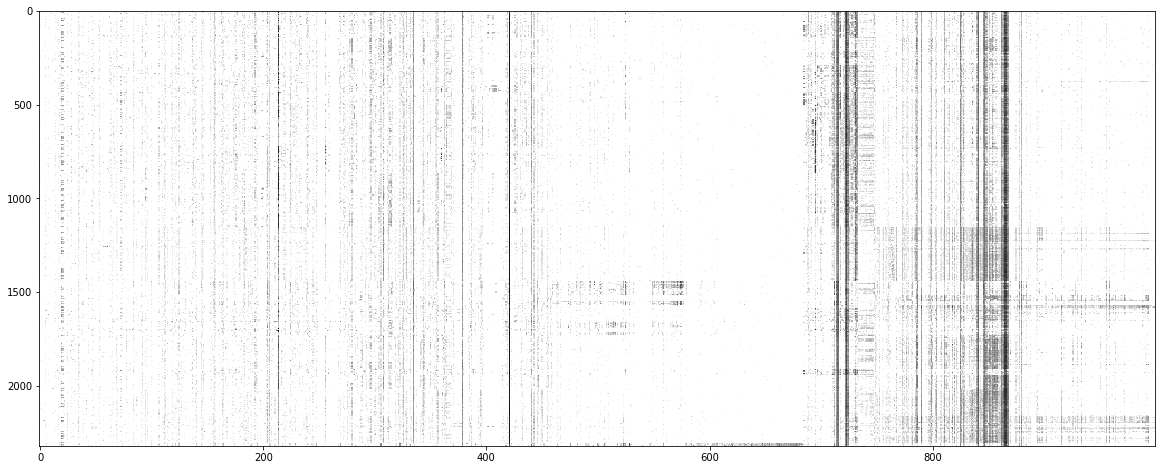

{0, 1, -1}


In [13]:
d_p_cell_clusters = HDBSCAN(min_samples=5).fit_predict(training_counts)
d_p_feature_clusters = HDBSCAN(min_samples=5).fit_predict(training_counts.T)

d_p_cell_ordering = np.argsort(d_p_cell_clusters)
# d_p_feature_ordering = np.argsort(d_p_feature_clusters)

plt.figure(figsize=(20,8))
plt.imshow(training_counts[d_p_cell_ordering],aspect='auto',cmap='binary')
plt.show()

print(set(d_p_cell_clusters))

In [15]:
from sklearn.manifold import TSNE

t_coordinates = TSNE().fit_transform(counts)

plt.figure(figsize=(15,10))
plt.title("Cells Transformed by TSNE (Arbitrary Units)",fontsize=20)
plt.scatter(t_coordinates[:,0],t_coordinates[:,1],s=.1,cmap='rainbow')
plt.show()

# for cluster in set(cell_clusters):
#     print(np.sum(np.array(cell_clusters) == cluster))

SyntaxError: invalid syntax (<ipython-input-15-e670b1d374f0>, line 10)

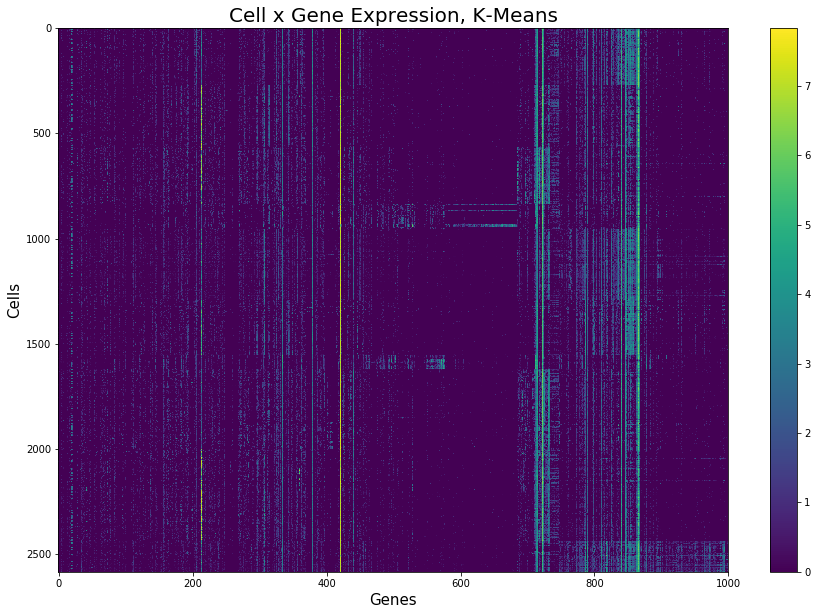

In [18]:
from sklearn.cluster import KMeans

k_cell_clusters = KMeans(n_clusters=10).fit_predict(counts)

k_cell_ordering = np.argsort(k_cell_clusters)

plt.figure(figsize=(15,10))
plt.title("Cell x Gene Expression, K-Means",fontsize=20)
plt.imshow(counts[k_cell_ordering],aspect='auto')
plt.xlabel("Genes",fontsize=15)
plt.ylabel("Cells",fontsize=15)
plt.colorbar()
plt.show()

In [ ]:
# sys.path.append("/Users/boris/haxx/python")
# import reborrow_clustering.reborrow as rbc

# encoding = forest.node_sample_encoding(forest.leaves())

# np.savetxt("/Users/boris/haxx/python/reborrow_clustering/encoding.txt",encoding)

# cell_clusters = rbc.cluster(encoding)
# leaf_clusters = rbc.cluster(encoding.T)

# cell_ordering = np.argsort(cell_clusters)
# leaf_ordering = np.argsort(leaf_clusters)

# plt.figure(figsize=(20,8))
# plt.imshow(encoding[cell_ordering].T[leaf_ordering].T,aspect='auto',cmap='binary')
# plt.show()

In [ ]:
random_mask = np.random.rand(*true_counts.flatten().shape) < (subsampling/10)

plt.figure("general_scatter")
plt.title("True Expression vs Predicted Expression")
plt.scatter(true_counts.flatten()[random_mask],predicted.flatten()[random_mask],s=.1,alpha=.3)
plt.xlabel("True Expression")
plt.ylabel("Predicted Expression")
plt.savefig(output_directory+"general_scatter.png")

In [ ]:

plt.figure("mae_vs_mean",figsize=(20,4))
plt.title("Mean Absolute Error of Feature Predictions vs Mean Feature Value")
plt.scatter(np.mean(true_counts,axis=0),np.mean(np.abs(true_counts - predicted), axis=0),s=.1)
plt.plot([0,4],[0,4],c='r')
plt.xlabel("Mean Gene Expression")
plt.ylabel("Mean Absolute Error")
plt.ylim((0,4))
plt.savefig(output_directory+"mae_vs_mean.png")

# Calculate MAE
mae = np.mean(np.abs(true_counts - np.tile(np.mean(true_counts,axis=0),(true_counts.shape[0],1))), axis=0)

plt.figure("mean_abs_dev_vs_mean",figsize=(20,4))
plt.title("Mean Absolute Deviation of Features vs Expression Level")
plt.scatter(np.mean(true_counts,axis=0),mae,s=.1)
plt.plot([0,4],[0,4],c='r')
plt.xlabel("Mean Gene Expression")
plt.ylabel("Mean Absolute Deviation")
plt.ylim((0,4))
plt.savefig(output_directory+"mean_abs_dev_vs_mean.png")

In [ ]:
random_mask = np.random.rand(*true_counts.flatten().shape) < subsampling

plt.figure("bimodal_scatter_by_mean",figsize=(20,4))
plt.title("Observed Expressions Vs Mean Expression of Feature")
plt.scatter(np.tile(np.mean(true_counts,axis=0),(true_counts.shape[0],1)).flatten()[random_mask],true_counts.flatten()[random_mask],s=.1,alpha=.1, label="Observed Expression")
# plt.scatter(np.mean(true_counts,axis=0),np.median(true_counts,axis=0),c='r',s=.5, label="Mean Expression")
plt.xlabel("Mean Expression")
plt.ylabel("Observed Expression")
plt.legend()
plt.savefig(output_directory+"bimodal_scatter_by_mean.png")

In [ ]:
# print true_counts[:10,:10]

random_mask = np.random.rand(*true_counts.flatten().shape) < subsampling

plt.figure("bimodal_scatter_by_mean_predicted",figsize=(20,4))
plt.title("Predicted Values Vs Observed Means")
plt.scatter(np.tile(np.mean(true_counts,axis=0),(true_counts.shape[0],1)).flatten()[random_mask],predicted.flatten()[random_mask],s=.1,alpha=.1,label="Expression")
plt.scatter(np.mean(true_counts,axis=0),np.median(true_counts,axis=0),c='m',s=.5,label="Medians")
plt.scatter(np.mean(true_counts,axis=0),np.mean(true_counts,axis=0),c='c',s=.5,label="Means")
plt.legend()
plt.savefig(output_directory+"bimodal_scatter_by_mean_predicted.png")

In [ ]:
random_mask = np.random.rand(*true_counts.flatten().shape) < subsampling

plt.figure("error_scatter_by_mean", figsize=(20,4))
plt.title("Observed Error vs Observed Mean of Feature")
plt.scatter(np.tile(np.mean(true_counts,axis=0),(true_counts.shape[0],1)).flatten()[random_mask],(true_counts - predicted).flatten()[random_mask],alpha=.1,s=.1)
plt.xlabel("Mean Expression")
plt.ylabel("Predicted Expression")
plt.savefig(output_directory+"error_scatter_by_mean.png")

In [ ]:
plt.figure("mean_error_vs_mean",figsize=(20,4))
plt.title("Mean Absolute Error Vs Mean Expression of Gene")
plt.scatter(np.mean(true_counts,axis=0),np.mean(np.abs(true_counts-predicted),axis=0),s=.1,c=np.std(true_counts,axis=0))
plt.colorbar(label="Standard Deviation of Feature")
# plt.plot([0,3],[0,3])
plt.ylim((0,4))
plt.xlabel("Mean Expression")
plt.ylabel("Mean Error")
plt.savefig(output_directory+"mean_error_vs_mean.png")

In [ ]:
plt.figure("mean_error_vs_std",figsize=(4,4))
plt.title("Mean Absolute Error Vs Standard Deviation of Gene Expression")
plt.scatter(np.std(true_counts,axis=0),np.mean(np.abs(true_counts-predicted),axis=0),s=.1)
# plt.colorbar(label="Standard Deviation of Feature")
plt.plot([0,4],[0,4])
plt.ylim((0,4))
plt.xlim((0,4))
plt.xlabel("Standard Deviation")
plt.ylabel("Mean Error")
plt.savefig(output_directory+"mean_error_vs_std.png")

In [ ]:
# true_counts = np.loadtxt('../raw_data/counts.txt')
# predicted = np.loadtxt('./predictions/combined_mixed')

correlations = []

for i in range(true_counts.shape[1]):
    
    correlations.append(pearsonr(true_counts[:,i],predicted[:,i])[0])
    if isnan(correlations[-1]):
        correlations[-1] = 0
        

print(len(correlations))

plt.figure("correlation_vs_mean",figsize=(20,4))
plt.title("Correlation of Predictions to Features per Feature")
plt.scatter(np.mean(true_counts,axis=0),correlations,s=.1,c=np.std(true_counts,axis=0))
plt.colorbar(label="Standard Deviation of Feature")
plt.xlabel("Mean Expression")
plt.ylabel("Prediction Correlation")
plt.savefig(output_directory+"correlation_vs_mean.png")

In [ ]:
from scipy.stats import linregress

x = np.std(true_counts,axis=0)
y = np.mean(true_counts-predicted,axis=0)

slope, intercept, rvalue, pvalue, std_err = linregress(x, y=y)

plt.figure("mean_error_vs_variance")
plt.title("Standard Deviation vs Mean Error")
plt.scatter(x,y,s=.1)
# plt.plot(x,x*slope + intercept, 'r', label = str(np.around(rvalue,decimals=3)))
plt.plot([0,3],[0,3])
plt.plot([0,3],[0,-3])
plt.ylim((-3,3))
plt.xlabel("Standard Deviation")
plt.ylabel("Mean Error")
plt.legend()
plt.savefig(output_directory+"mean_error_vs_variance.png")

In [ ]:
# predicted = np.loadtxt('./predictions/combined_prediction')
correlations = []

for i in range(true_counts.shape[1]):
    correlations.append(pearsonr(true_counts[:,i],predicted[:,i])[0])
    if isnan(correlations[-1]):
        correlations[-1] = 0
print(len(correlations))

    
plt.figure("correlation_vs_mean",figsize=(20,4))
plt.title("Correlation of Predictions vs Expression Level")
plt.scatter(correlations,np.mean(true_counts,axis=0),s=.3,c=variation(true_counts,axis=0))
plt.ylabel("Mean Expression")
plt.xlabel("Correlation")
plt.colorbar(label="Coefficient of Variation")
plt.clim(0,10)
plt.savefig(output_directory+"correlation_vs_mean_vs_cov.png",dpi=500)

In [ ]:
correlations = []

for i in range(true_counts.shape[1]):
    correlations.append(pearsonr(true_counts[:,i],predicted[:,i])[0])
    if isnan(correlations[-1]):
        correlations[-1] = 0
    
print(len(correlations))

plt.figure("correlation_vs_cov")
plt.title("Correlation of features vs Coefficient of Variance")
plt.xlabel("Coefficient of Variation")
plt.ylabel("Correlation")
plt.scatter(variation(true_counts,axis=0),correlations,s=.1,c=np.std(true_counts,axis=0))
plt.colorbar(label="Standard Deviation of Feature")
plt.xlim(0,2)
plt.show()

In [ ]:
random_mask = np.random.rand(*true_counts.flatten().shape) < (subsampling/10.0)

errors = true_counts - predicted

plt.figure("error_vs_true_expression")
plt.title("Error vs True Expression")
plt.scatter(true_counts.flatten()[random_mask],errors.flatten()[random_mask],s=.1,alpha=.3,c=np.tile(np.mean(true_counts,axis=0),(true_counts.shape[0],1)).flatten()[random_mask],cmap='inferno')
plt.xlabel("True Expression")
plt.ylabel("Error")
plt.colorbar(label="Mean expression of gene")
plt.savefig(output_directory+"error_vs_true_expression.png")

In [ ]:
error = predicted - true_counts 

mean_cell_error = np.mean(error,axis=1)
mean_gene_error = np.mean(error,axis=0)

print(mean_gene_error.shape)
print(mean_cell_error.shape)

plt.figure()
plt.title("Distribution of Mean Feature Errors")
plt.hist(mean_gene_error,bins=20)
plt.xlabel("Mean Error")
plt.ylabel("Frequency")
plt.show()

plt.figure()
plt.title("Distribution of Mean Cell Errors")
plt.hist(mean_cell_error,bins=20)
plt.xlabel("Mean Error")
plt.ylabel("Frequency")
plt.show()


In [ ]:
expression_sorted_features = true_counts.T[np.argsort(np.mean(true_counts,axis=0))].T
expression_sorted_prediction = predicted.T[np.argsort(np.mean(true_counts,axis=0))].T


plt.figure("predictability")
plt.title("Correlation of Features to Other Features, Sorted By Mean Expression")
plt.imshow(np.corrcoef(expression_sorted_features.T))
plt.colorbar(label="Correlation")
plt.show()


In [ ]:
random_mask = np.random.rand(*expression_sorted_features.flatten().shape) < subsampling

plt.figure("ranked_feature_expression",figsize=(20,4))
plt.title("Observed Expressions For Each Feature Ranked By Mean Expression")
plt.scatter(np.tile(np.arange(expression_sorted_features.shape[1]),(expression_sorted_features.shape[0],1)).flatten()[random_mask],expression_sorted_features.flatten()[random_mask],s=.1,alpha=.1, label="Observed Expression")
# plt.scatter(np.mean(true_counts,axis=0),np.median(true_counts,axis=0),c='r',s=.5, label="Mean Expression")
plt.xlabel("Feature Rank")
plt.ylabel("Observed Expression")
plt.ylim((0,10))
plt.legend()
plt.savefig(output_directory+"rank_ordered_expresssion.png")

In [ ]:
import random

for j in range(10):
    i = random.randint(1,true_counts.shape[0])
    plt.figure('cell_multiplex' + str(i))
    plt.scatter(np.arange(expression_sorted_features.shape[1]),expression_sorted_features[i],s=.1)
    plt.show()

In [ ]:
for j in range(10):
    i = random.randint(1,expression_sorted_features.shape[1])
    plt.figure("feature_dist_multiplex" + str(i))
    plt.hist(expression_sorted_features[:,i],bins=50,log=True)
    plt.show()

# deciles = np.zeros((20,expression_sorted_features.shape[1]))
# derivatives = np.zeros((19,expression_sorted_features.shape[1]))
# for i,feature in enumerate(expression_sorted_features.T):
#     bins,edges = np.histogram(feature,bins=20,range=(np.min(feature),np.max(feature)))
# #     print(bins)
# #     print(edges)
# #     print(np.array([y-x for x,y in zip(bins,bins[1:])]))
#     deciles[:,i] = bins
#     derivatives[:,i] = np.array([y-x for x,y in zip(bins,bins[1:])])

# plt.figure(figsize=(20,4))
# plt.imshow(deciles,aspect='auto')
# plt.show()

# plt.figure(figsize=(20,4))
# plt.imshow(derivatives,aspect='auto')
# plt.show()

In [ ]:
# print true_counts[:10,:10]

# expression_sorted_features = true_counts.T[np.argsort(np.mean(true_counts,axis=0))].T

# expression_sorted_prediction = predicted.T[np.argsort(np.mean(true_counts,axis=0))].T

# random_mask = np.random.rand(*expression_sorted_features.flatten().shape) < (subsampling)

plt.figure("ranked_feature_predicted",figsize=(20,4))
plt.title("Predicted Values By Mean Expression Ranking")
plt.scatter(np.tile(np.arange(expression_sorted_features.shape[1]),(expression_sorted_features.shape[0],1)).flatten()[random_mask],expression_sorted_prediction.flatten()[random_mask],s=.05,alpha=.3,label="Expression",c=np.abs(expression_sorted_prediction-expression_sorted_features).flatten()[random_mask],cmap='plasma')
# plt.scatter(np.arange(expression_sorted_features.shape[1]),np.median(expression_sorted_features,axis=0),c='m',s=.5,label="Medians")
# plt.scatter(np.arange(expression_sorted_features.shape[1]),np.mean(expression_sorted_features,axis=0),c='c',s=.5,label="Means")
plt.legend()
plt.colorbar(label="Absolute Value of Error")
plt.clim(0,10)
plt.savefig(output_directory+"rank_ordered_predicted.png",dpi=500)

In [ ]:
random_mask = np.random.rand(*expression_sorted_features.flatten().shape) < subsampling

plt.figure("error_scatter_ranked", figsize=(20,4))
plt.title("Observed Error By Mean Expression Ranking")
plt.scatter(np.tile(np.arange(expression_sorted_features.shape[1]),(expression_sorted_features.shape[0],1)).flatten()[random_mask],(expression_sorted_features - expression_sorted_prediction).flatten()[random_mask],alpha=.1,s=.1)
plt.xlabel("Rank")
plt.ylabel("Predicted Expression")
plt.savefig(output_directory+"rank_ordered_error.png")

In [ ]:
correlations = []

for i in range(true_counts.shape[1]):
    
    correlations.append(pearsonr(true_counts[:,i],predicted[:,i])[0])
    if isnan(correlations[-1]):
        correlations[-1] = 0
        
plt.figure("correlation_vs_mean",figsize=(20,4))
plt.title("Correlation of Predictions per Expression Ranked Feature")
plt.scatter(np.arange(len(correlations)),np.array(correlations)[np.argsort(np.mean(true_counts,axis=0))],s=.1)
plt.xlabel("Feature Mean Expression Rank")
plt.ylabel("Prediction Correlation")
plt.savefig(output_directory+"ranked_correlation.png")

In [ ]:
import random
 
j = 0

while j < 10:
    i = random.randint(1,expression_sorted_features.shape[1])
    if pearsonr(expression_sorted_features[:,i],expression_sorted_prediction[:,i])[0] < .5:
        continue
    plt.figure('feature_pred_multiplex' + str(i))
    plt.gca().axis('equal')
    plt.title("Mean Expresion: " + str(np.mean(expression_sorted_features[:,i])) + " Corr: " + str(pearsonr(expression_sorted_features[:,i],expression_sorted_prediction[:,i])[0]))
    plt.scatter(expression_sorted_features[:,i],expression_sorted_prediction[:,i],s=1)
    plt.xlabel("True Expression")
    plt.ylabel("Predicted Expression")
    plt.show()
    
    j += 1

In [ ]:
correlations = []

for i in range(expression_sorted_features.shape[1]):
    
    correlations.append(pearsonr(expression_sorted_features[:,i],expression_sorted_prediction[:,i])[0])
    if isnan(correlations[-1]):
        correlations[-1] = 0
    
print(len(correlations))
print(correlations[:10])
print(np.arange(.05,1,.05))
    
plt.figure("correlation_histogram")
plt.title("Distribution of Feature Correlations")
plt.hist(correlations,bins=np.arange(0,1,.05))
plt.savefig(output_directory+"correlation_distributions.png")

In [ ]:
# pearsonr(true_counts.flatten(),imputed_gradient.flatten())

In [ ]:
# plt.figure()
# plt.title("Median Random Forest Prediction")
# plt.xlabel("Truth")
# plt.ylabel("Imputed")
# plt.scatter(truth,pred_basic_forest,s=.003)
# plt.plot([0,15],[0,15])
# plt.savefig('figures/basic_error_scatter.png')

In [ ]:
# print np.var(predicted,axis=0).shape

# plt.figure("means")
# plt.title("Distribution of Means")
# plt.hist(np.mean(true_counts,axis=0),bins=np.arange(20),alpha=.1,label="Data")
# plt.show()

# plt.figure("stds")
# plt.title("Distribution of Standard Deviations")
# plt.hist(np.std(true_counts,axis=0), bins=np.arange(20),alpha=.1,label="Data")
# plt.show()

# plt.figure("naive_mae")
# plt.title("Distribution of Means of Error")
# plt.hist(np.mean(np.abs(true_counts - predicted), axis=0),bins=np.arange(20),alpha=.1,label="Error")
# plt.show()

# plt.figure("naive_mse")
# plt.title("Distribution of MSE per feature")
# plt.hist(np.mean((true_counts - predicted)**2, axis=0),bins=np.arange(20),alpha=.1,label="Error")
# plt.show()

# np.random.shuffle(predicted)
# plt.figure("mae_shuffled")
# plt.title("Distribution of Means of Error (Shuffled)")
# plt.hist(np.var(np.abs(true_counts - predicted),axis=0),bins=np.arange(20),alpha=.1,label="Shuffled")
# # plt.legend()
# plt.show()


In [ ]:
# plt.figure()
# plt.title("Gradient Random Forest Prediction")
# plt.xlabel("Truth")
# plt.ylabel("Imputed")
# plt.scatter(truth,pred_gradient,s=.003)
# plt.plot([0,15],[0,15])
# plt.savefig('figures/gradient_error_scatter.png')

In [ ]:
# print np.sum(true_counts,axis=1).shape

# plt.figure("cell_histograms")
# plt.title("Frequency of Total Cell Counts")
# plt.hist(np.sum(true_counts,axis=1))

# plt.show()

In [ ]:
# power = 2

# print(np.sum(true_counts,axis=1).shape)

# plt.figure("cell_histograms")
# plt.title("Frequency of Total Cell Counts (Log)")
# plt.hist(np.sum(np.power(true_counts,power),axis=1))
# plt.show()

In [ ]:
# plt.figure()
# plt.title("KNN Imputation")
# plt.xlabel("Truth")
# plt.ylabel("Imputed")
# plt.scatter(truth,pred_knn,s=.003)
# plt.plot([0,15],[0,15])
# plt.savefig('figures/knn_error_scatter.png')

In [ ]:
# plt.figure()
# plt.title("Soft Imputation Prediction")
# plt.xlabel("Truth")
# plt.ylabel("Imputed")
# plt.scatter(truth,pred_soft,s=.003)
# plt.plot([0,15],[0,15])
# plt.savefig('figures/soft_error_scatter.png')

In [ ]:
# plt.figure()
# plt.title("Sklearn Random Forest Prediction")
# plt.xlabel("Truth")
# plt.ylabel("Imputed")
# plt.scatter(truth,pred_builtin,s=.003)
# plt.plot([0,15],[0,15])
# plt.savefig('figures/sklearn_rf_error_scatter.png')

In [ ]:
# true_iris = np.loadtxt('./testing/iris.trunc')
# dropped_iris = np.loadtxt('./testing/iris.drop')
# nan_iris = dropped_iris.copy()
# nan_iris[nan_iris == 0] = np.nan

# forest_prediction = np.loadtxt('./iris_test/run.prediction')

In [ ]:
# soft_iris = fi.SoftImpute().complete(nan_iris)

# knn_iris = fi.KNN(k=15).complete(nan_iris)

# factorized_iris = fi.MatrixFactorization().complete(nan_iris)

# iterative_iris = fi.IterativeSVD(rank=5).complete(nan_iris)

In [ ]:

# guess_mask = dropped_iris.flatten() == 0

# truth = true_iris.flatten()[guess_mask] 

# print "Pearson correlations of Soft, KNN, Factorized, and Forest"
# print pearsonr(soft_iris.flatten()[guess_mask],truth)
# print pearsonr(knn_iris.flatten()[guess_mask],truth)
# print pearsonr(factorized_iris.flatten()[guess_mask],truth)
# print pearsonr(forest_prediction.flatten()[guess_mask],truth)

# print "MSE of Soft, KNN, Factorized, and Forest"
# print np.mean(((soft_iris.flatten()[guess_mask] - truth) ** 2))
# print np.mean(((knn_iris.flatten()[guess_mask] - truth) ** 2))
# print np.mean(((factorized_iris.flatten()[guess_mask] - truth) ** 2))
# print np.mean(((forest_prediction.flatten()[guess_mask] - truth) ** 2))


In [ ]:
# plt.figure("soft_iris")
# plt.title("Soft Imptuation of the Iris Dataset")
# plt.xlabel("Imputed")
# plt.ylabel("True")
# plt.scatter(soft_iris.flatten()[guess_mask],true_iris.flatten()[guess_mask],s=1)
# plt.plot([0,8],[0,8])
# plt.tight_layout()
# plt.savefig("figures/soft_iris_scatter.png")

# plt.figure("knn_iris")
# plt.title("KNN Imptuation of the Iris Dataset")
# plt.xlabel("Imputed")
# plt.ylabel("True")
# plt.scatter(knn_iris.flatten()[guess_mask],true_iris.flatten()[guess_mask],s=1)
# plt.plot([0,8],[0,8])
# plt.tight_layout()
# plt.savefig("figures/knn_iris_scatter.png")

# plt.figure("factorized_iris")
# plt.title("Matrix Factorization Imptuation of the Iris Dataset")
# plt.xlabel("Imputed")
# plt.ylabel("True")
# plt.scatter(factorized_iris.flatten()[guess_mask],true_iris.flatten()[guess_mask],s=1)
# plt.plot([0,8],[0,8])
# plt.tight_layout()
# plt.savefig("figures/factorized_iris_scatter.png")

# plt.figure("forest_iris")
# plt.title("Median Forest (Non-Gradient) Imptuation of the Iris Dataset")
# plt.xlabel("Imputed")
# plt.ylabel("True")
# plt.scatter(forest_prediction.flatten()[guess_mask],true_iris.flatten()[guess_mask],s=1)
# plt.plot([0,8],[0,8])
# plt.tight_layout()
# plt.savefig("figures/forest_iris_scatter.png")

In [ ]:
# nan_counts = held_out_counts.copy()
# nan_counts[nan_counts == 0] = np.nan

# soft_blood = fi.SoftImpute().complete(nan_counts)

# knn_blood = fi.KNN(k=15).complete(nan_counts)

In [ ]:
# mask = mask.astype(dtype=bool)
# # mask = np.logical_and(true_counts != 0, mask)

# truth = true_counts[mask].flatten()
# pred_basic_forest = imputed_basic[mask].flatten()
# pred_gradient = imputed_gradient[mask].flatten()

# pred_builtin = imputed_builtin[mask].flatten()

# pred_knn = knn_blood[mask].flatten()
# pred_soft = soft_blood[mask].flatten()

# print "Pearson of random, gradient, builtin, knn, and soft"

# print pearsonr(truth,pred_basic_forest)
# print pearsonr(truth,pred_gradient)
# print pearsonr(truth,pred_builtin)
# print pearsonr(truth,pred_knn)
# print pearsonr(truth,pred_soft)

# print "MSE of random, gradient, builtin, knn, and soft"

# print np.mean((pred_basic_forest - truth) ** 2)
# print np.mean((pred_gradient - truth) ** 2)
# print np.mean((pred_builtin - truth) ** 2)
# print np.mean((pred_knn - truth) ** 2)
# print np.mean((pred_soft - truth) ** 2)

# print "Mean absolute error"
# print np.mean(np.abs(pred_basic_forest - truth))
# print np.mean(np.abs(pred_gradient - truth))
# print np.mean(np.abs(pred_builtin - truth))
# print np.mean(np.abs(pred_knn - truth))
# print np.mean(np.abs(pred_soft - truth))


In [ ]:
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import train_test_split
# from scipy.stats import pearsonr

# import time

# start_time = time.time()

# for i in range(10):

#     print "Selecting features"
    
#     in_features = np.random.rand(true_counts.shape[1]) > .7
#     out_features = np.logical_not(in_features)

#     training_samples = np.random.rand(true_counts.shape[0]) > .3
#     testing_samples = np.logical_not(training_samples)

#     training_in = true_counts[training_samples].T[in_features].T
#     training_out = true_counts[training_samples].T[out_features].T

#     testing_in = true_counts[testing_samples].T[in_features].T
#     testing_out = true_counts[testing_samples].T[out_features].T

#     print "Initializing feature"
    
#     forest = GradientBoostingRegressor()

#     print "Fitting"
    
#     forest.fit(training_in,training_out)
    
#     print "Predicting"
    
#     prediction = forest.predict(testing_in)

#     print np.sum(in_features)
#     print np.sum(out_features)
#     print np.sum(training_samples)
#     print np.sum(testing_samples)
    
#     print prediction.shape
#     print testing_out.shape
    
#     print "Pearson R"
#     print pearsonr(testing_out.flatten(),prediction.flatten())
    
#     print "MSE"
#     print np.mean((prediction.flatten() - testing_out.flatten()) ** 2)
    
#     print "MAE"
#     print np.mean(np.abs(prediction.flatten() - testing_out.flatten()))

    
# print "Fitting done"

# end_time = time.time()

# print start_time - end_time

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from scipy.stats import pearsonr

# import time

# start_time = time.time()

# for i in range(10):

#     print "Selecting features"
    
#     in_features = np.random.rand(true_counts.shape[1]) > .7
#     out_features = np.logical_not(in_features)

#     training_samples = np.random.rand(true_counts.shape[0]) > .3
#     testing_samples = np.logical_not(training_samples)

#     training_in = true_counts[training_samples].T[in_features].T
#     training_out = true_counts[training_samples].T[out_features].T

#     testing_in = true_counts[testing_samples].T[in_features].T
#     testing_out = true_counts[testing_samples].T[out_features].T

#     print "Initializing feature"
    
#     forest = RandomForestRegressor(n_estimators=100,min_samples_split=50,n_jobs=int(10),max_features=400)

#     print "Fitting"
    
#     forest.fit(training_in,training_out)
    
#     print "Predicting"
    
#     prediction = forest.predict(testing_in)

#     print np.sum(in_features)
#     print np.sum(out_features)
#     print np.sum(training_samples)
#     print np.sum(testing_samples)
    
#     print prediction.shape
#     print testing_out.shape
    
#     print "Pearson R"
#     print pearsonr(testing_out.flatten(),prediction.flatten())
    
#     print "MSE"
#     print np.mean((prediction.flatten() - testing_out.flatten()) ** 2)
    
#     print "MAE"
#     print np.mean(np.abs(prediction.flatten() - testing_out.flatten()))

    
# print "Fitting done"

# end_time = time.time()

# print start_time - end_time